# Imports

In [1]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

import pandas as pd
import numpy as np

from IPython.display import display
from PIL import Image

Make the results reproducible

In [2]:
set_seed(420)

# Setup

In [3]:
path_str = './data'
PATH = Path(path_str)

images_path = Path(path_str + '/train_images') # X
csv_path = Path(path_str + '/train.csv') # X and Y

# Some Data Analysis

Get the default image height and width

In [4]:
test_image = Image.open((images_path).ls()[6])

test_image.shape

(600, 800)

View the csv data

In [5]:
train_df = pd.read_csv(csv_path)
train_df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

# Create a smaller dataset

In [6]:
#msk = np.random.rand(len(train_df)) < 0.2

In [7]:
#small_df = train_df[msk]
#small_df['label'].value_counts(), len(small_df)

(3    2675
 4     495
 2     474
 1     456
 0     239
 Name: label, dtype: int64,
 4339)

# Data Preprocessing

In [7]:
def get_x(row): return images_path/row['image_id']
def get_y(row): return row['label']

In [8]:
blocks = (ImageBlock, CategoryBlock)
splitter = RandomSplitter(valid_pct=0.2)
item_tfms = [Resize(480)]
batch_tfms = [RandomResizedCropGPU(280), *aug_transforms(flip_vert=True,
                                                         do_flip=True), Normalize.from_stats(*imagenet_stats)]

block = DataBlock(blocks=blocks, get_x=get_x, get_y=get_y, splitter=splitter, item_tfms=item_tfms, batch_tfms=batch_tfms)

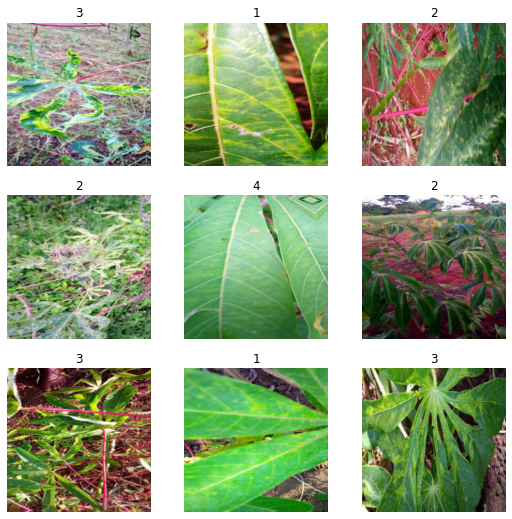

In [9]:
dls = block.dataloaders(train_df, bs=16)

dls.show_batch()

# Model

In [10]:
loss_func = LabelSmoothingCrossEntropy()
optimizer = ranger
learn = cnn_learner(dls, resnet50, loss_func=loss_func, metrics=accuracy, opt_func=optimizer).to_fp16()

# Training

/home/teo/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


0.0006309573538601399

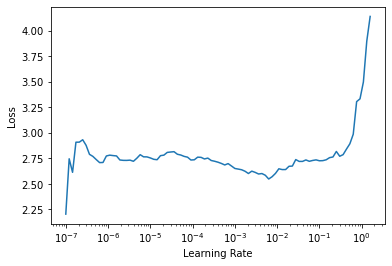

In [11]:
lr_min, lr_steep = learn.lr_find()
lr_min

In [12]:
round(lr_min, 7)

0.000631

In [13]:
learn.fine_tune(10, base_lr=1e-2, freeze_epochs=7)

epoch,train_loss,valid_loss,accuracy,time
0,1.238766,1.073136,0.694555,08:57
1,0.999122,0.964169,0.724001,08:56
2,0.971101,0.914525,0.751577,08:54
3,0.880413,0.836350,0.781257,08:56
4,0.866034,0.776649,0.817948,08:54
5,0.820540,0.790991,0.820753,08:55
6,0.779079,0.726169,0.841084,08:56


epoch,train_loss,valid_loss,accuracy,time
0,0.795754,0.733081,0.835709,11:39
1,0.845379,0.748202,0.836410,11:37
2,0.810312,0.744121,0.837345,11:38
3,0.776846,0.709869,0.848095,11:37
4,0.789770,0.712864,0.848796,11:34
5,0.757225,0.706516,0.846459,11:37
6,0.728725,0.679119,0.862818,11:37
7,0.699805,0.670769,0.868194,11:37
8,0.695750,0.664071,0.871933,11:38
9,0.680922,0.659264,0.875205,11:38


In [14]:
learn.export(Path("./models/fastai-model.pkl"))

# Results

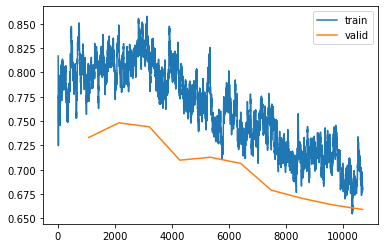

In [15]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=5)

# Submit

In [ ]:
submission_df = pd.read_csv(path_str + '/sample_submission.csv')
test_data_path = submission_df['image_id'].apply(lambda x: path_str+'/test_images/'+x)

tst_dl = learn.dls.test_dl(test_data_path)

In [ ]:
predictions = learn.tta(dl=tst_dl, n=10)

In [ ]:
submission_df['label'] = np.argmax(predictions[0], axis=1)

submission_df.to_csv('submission.csv',index=False)